列出可用的模型


In [1]:
import google.generativeai as genai

# 列出所有可用的模型
available_models = genai.list_models()

# 輸出支持調整的模型
for model in available_models:
    if "createTunedModel" in model.supported_generation_methods:
        print(f"Model ID: {model.name}, Name: {model.display_name}")

Model ID: models/gemini-1.0-pro-001, Name: Gemini 1.0 Pro 001 (Tuning)


準備訓練數據


In [2]:
training_data = (
    [
        # 簡單的數字增量
        {"text_input": "1", "output": "2"},
        {"text_input": "3", "output": "4"},
        # 負數的增量
        {"text_input": "-3", "output": "-2"},
        # 數字文字形式的增量
        {"text_input": "twenty two", "output": "twenty three"},
        # 高數字文字形式的增量
        {"text_input": "two hundred", "output": "two hundred one"},
        # 跨越進位的增量
        {"text_input": "ninety nine", "output": "one hundred"},
        {"text_input": "8", "output": "9"},
        {"text_input": "-98", "output": "-97"},
        # 含千位分隔符的增量
        {"text_input": "1,000", "output": "1,001"},
        {"text_input": "10,100,000", "output": "10,100,001"},
        {"text_input": "thirteen", "output": "fourteen"},
        {"text_input": "eighty", "output": "eighty one"},
        {"text_input": "one", "output": "two"},
        {"text_input": "three", "output": "four"},
        {"text_input": "seven", "output": "eight"}
    ]
)

創建調整模型

In [3]:
import google.generativeai as genai
import random

# 設置調整模型的名稱
model_id = "models/gemini-1.0-pro-001"
name = f"generate-num-{random.randint(0, 10000)}"
# 創建調整模型
operation = genai.create_tuned_model(
    # 使用支持調整的模型 ID
    source_model=model_id,
    # 提供訓練數據
    training_data=training_data,
    # 調整模型的唯一標識
    id=name,
    # 訓練週期數
    epoch_count=10,
    # 每批訓練數據的大小
    batch_size=2,
    # 學習速率
    learning_rate=0.001,
    # 設置模型的顯示名稱
    display_name="我的調整模型"
)
# 等待操作完成
operation.result()
print(f"調整模型創建完成，模型 ID: {name}")

調整模型創建完成，模型 ID: generate-num-144


檢查調整模型的狀態


In [4]:
# 獲取調整模型的詳細信息
operation = genai.get_tuned_model(f"tunedModels/{name}")
print(f"模型狀態: {operation.state}")

# 列出已調整的模型
for i, m in zip(range(5), genai.list_tuned_models()):
    print(f"Model ID: {m.name}, Name: {m.display_name}")

模型狀態: 2
Model ID: tunedModels/number-generator-model-196mbgm8wd2, Name: number generator model
Model ID: tunedModels/number-generator-model-6503a0drn7zo, Name: number generator model
Model ID: tunedModels/number-generator-model-qxow3c46ru5d, Name: number generator model
Model ID: tunedModels/number-generator-model-bmz78102l9t6, Name: number generator model
Model ID: tunedModels/number-generator-model-gyw26dhike7r, Name: number generator model


檢查其輸出是否符合預期


In [5]:
# 創建生成內容的模型對象
model = genai.GenerativeModel(model_name=f"tunedModels/{name}")

# 測試模型輸出
test_cases = {
    "55": "56",
    "123455": "123456",
    "four": "five",
    # 法語的 4 和 5
    "quatre": "cinq",
    # 羅馬數字
    "III": "IV",
    # 日語的 7 和 8
    "七": "八",
}

for input_text, expected_output in test_cases.items():
    result = model.generate_content(input_text)
    print(f"Input: {input_text}, Output: {result.text}, Expected: {expected_output}")

Input: 55, Output: 56, Expected: 56
Input: 123455, Output: 6, Expected: 123456
Input: four, Output: five, Expected: five
Input: quatre, Output: cinq, Expected: cinq
Input: III, Output: IV, Expected: IV
Input: 七, Output: 八, Expected: 八


查看損失曲線


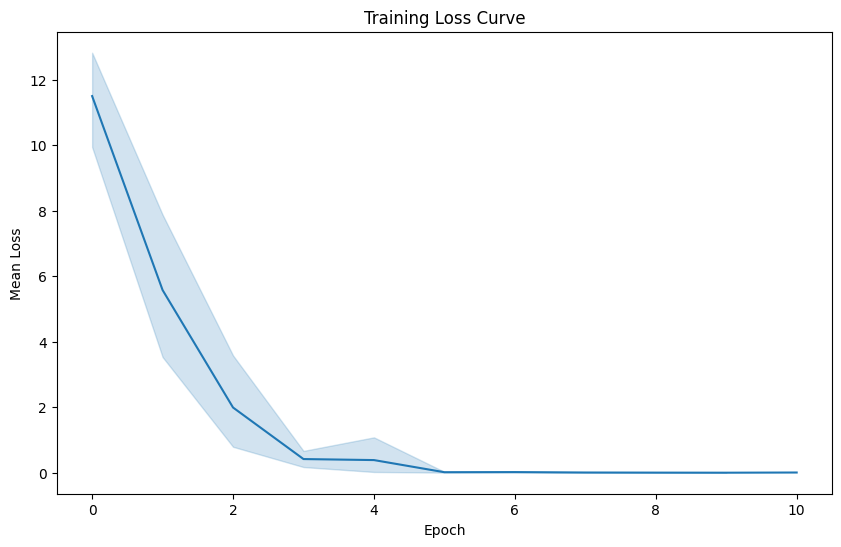

In [6]:
import google.generativeai as genai
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假設前面已經創建並獲取了調整模型
# 初始化並等待操作完成
# 獲取模型詳細信息
model_info = genai.get_tuned_model(f"tunedModels/{name}")

# 檢查模型是否有快照信息
if hasattr(model_info.tuning_task, "snapshots"):
    # 獲取調整模型的快照信息，構建 DataFrame
    snapshots = pd.DataFrame(model_info.tuning_task.snapshots)

    # 檢查 DataFrame 是否有數據
    if not snapshots.empty:
        # 繪製損失曲線
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=snapshots, x="epoch", y="mean_loss")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Loss")
        plt.title("Training Loss Curve")
        plt.show()
    else:
        print("沒有可用的 snapshots。")
else:
    print("該模型沒有 snapshots。")

更新調整模型的描述

In [7]:
# 更新調整模型的描述
genai.update_tuned_model(
    f"tunedModels/{name}",
    {"description": "This is my model."}
)

# 驗證更新
model_info = genai.get_tuned_model(f"tunedModels/{name}")
# 預期輸出：'This is my model.'
print(f"模型描述: {model_info.description}")

模型描述: This is my model.


刪除調整模型

In [9]:
# 刪除調整模型
genai.delete_tuned_model(f'tunedModels/{name}')
try:
    model_info = genai.get_tuned_model(f'tunedModels/{name}')
    print(model_info)
except Exception as e:
    # 預期輸出：404 Not Found
    print(f"{type(e)}: {e}")

NotFound: 404 Requested entity was not found.

列出和批次刪除已調整模型

In [8]:
import google.generativeai as genai

# 列出所有已調整的模型，將生成器轉換為列表
tuned_models = list(genai.list_tuned_models())

# 打印出所有模型的ID和名稱
print("已調整的模型列表:")
for model in tuned_models:
    print(f"Model ID: {model.name}, Name: {model.display_name}")

# 批次刪除模型
for model in tuned_models:
    try:
        # 刪除模型
        genai.delete_tuned_model(model.name)
        print(f"已刪除模型: Model ID: {model.name}, Name: {model.display_name}")
    except Exception as e:
        print(f"刪除模型失敗: Model ID: {model.name}, Name: {model.display_name}, Error: {e}")

# 列出刪除後的模型列表，並轉換為列表
remaining_models = list(genai.list_tuned_models())

print("刪除後的模型列表:")
for model in remaining_models:
    print(f"Model ID: {model.name}, Name: {model.display_name}")

# 確認所有模型是否已刪除
if not remaining_models:
    print("所有模型已刪除")
else:
    print(f"仍有 {len(remaining_models)} 個模型未刪除")


已調整的模型列表:
Model ID: tunedModels/number-generator-model-196mbgm8wd2, Name: number generator model
Model ID: tunedModels/number-generator-model-6503a0drn7zo, Name: number generator model
Model ID: tunedModels/number-generator-model-qxow3c46ru5d, Name: number generator model
Model ID: tunedModels/number-generator-model-bmz78102l9t6, Name: number generator model
Model ID: tunedModels/number-generator-model-gyw26dhike7r, Name: number generator model
Model ID: tunedModels/generate-num-144, Name: 我的調整模型
已刪除模型: Model ID: tunedModels/number-generator-model-196mbgm8wd2, Name: number generator model
已刪除模型: Model ID: tunedModels/number-generator-model-6503a0drn7zo, Name: number generator model
已刪除模型: Model ID: tunedModels/number-generator-model-qxow3c46ru5d, Name: number generator model
已刪除模型: Model ID: tunedModels/number-generator-model-bmz78102l9t6, Name: number generator model
已刪除模型: Model ID: tunedModels/number-generator-model-gyw26dhike7r, Name: number generator model
已刪除模型: Model ID: tunedMo